In [1]:
import imblearn
import numpy as np 
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle as pickle_rick
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

In [2]:
df = pd.read_csv('C:\\Users\\Yousef\\Desktop\\ml\\ML_Dataset\\spotify_training_classification.csv',parse_dates=['release_date'])

In [3]:
#pandas_profile = ProfileReport(df, title='Song Pop Profiling Report', explorative = True)
#pandas_profile.to_file("SongPopClass.html")

In [4]:
df['popularity_level']=df['popularity_level'].astype('category')
df['popularity_level'].cat.categories

Index(['High', 'Intermediate', 'Low'], dtype='object')

# Check Class imbalance

C:\Users\Yousef\Anaconda3\envs\spotify_model\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


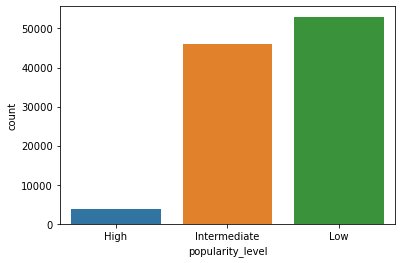

Low             52977
Intermediate    46111
High             3771
Name: popularity_level, dtype: int64


In [5]:
#check class imbalance

g = sns.countplot(df['popularity_level'])
g.set_xticklabels(['High','Intermediate','Low'])
plt.show()
print(df['popularity_level'].value_counts())

In [6]:
#rus = RandomUnderSampler(replacement=True)# fit predictor and target variable
#X = df.drop(['popularity_level'],axis=1)
#y = df['popularity_level']
#x_rus, y_rus = rus.fit_resample(X,y)
#df = pd.concat([x_rus,y_rus],axis = 1)
#print('original dataset shape:', Counter(y))
#print('Resample dataset shape', Counter(y_rus))

In [7]:
#ros = RandomOverSampler()
#X = df.drop(['popularity_level'],axis=1)
#y = df['popularity_level']
#x_ros, y_ros = ros.fit_resample(X, y)
#df = pd.concat([x_ros,y_ros],axis = 1)
#print('Original dataset shape', Counter(y))
#print('Resample dataset shape', Counter(y_ros))

In [8]:
def dataframe_nulls(dataframe):
    return dataframe.isnull().sum()
#dataframe_nulls(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102859 entries, 0 to 102858
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   valence           102099 non-null  float64       
 1   year              102121 non-null  float64       
 2   acousticness      102145 non-null  float64       
 3   artists           102024 non-null  object        
 4   danceability      102145 non-null  float64       
 5   duration_ms       101685 non-null  float64       
 6   energy            102145 non-null  float64       
 7   explicit          102145 non-null  float64       
 8   id                101906 non-null  object        
 9   instrumentalness  102145 non-null  float64       
 10  key               102145 non-null  float64       
 11  liveness          102145 non-null  float64       
 12  loudness          102145 non-null  float64       
 13  mode              102145 non-null  float64       
 14  name

In [10]:
categorical_cols = ['name','artists','key']

def unique_vals(dataframe,cat_cols):
    for c in cat_cols:
        print("{col} has {unique_val} unique values".format(col = c , unique_val = dataframe[c].nunique()))

unique_vals(df,categorical_cols)



name has 79731 unique values
artists has 22456 unique values
key has 12 unique values


In [11]:
print(df.duplicated().sum())
df = df[~df.duplicated()==1]

712


In [12]:
def fill_missing_values(df):
    df['valence'].fillna(df['valence'].median(),inplace=True)
    df['year'].fillna(df['year'].mean(),inplace=True)
    df['acousticness'].fillna(df['acousticness'].median(),inplace=True)
    df['danceability'].fillna(df['danceability'].median(),inplace=True)
    df['duration_ms'].fillna(df['duration_ms'].median(),inplace=True)
    df['energy'].fillna(df['energy'].mean(),inplace=True)
    df['explicit'].fillna(0,inplace=True)
    df['id'].fillna(df['id'].mode().iloc[0],inplace=True)
    df['instrumentalness'].fillna(df['instrumentalness'].median(),inplace=True)
    df['key'].fillna(df['key'].median(),inplace=True)
    df['liveness'].fillna(df['liveness'].mean(),inplace=True)
    df['loudness'].fillna(df['loudness'].median(),inplace=True)
    df['mode'].fillna(0,inplace=True)
    df['name'].fillna(df['name'].mode().iloc[0],inplace=True)
    df['tempo'].fillna(df['tempo'].median(),inplace=True)
    df['release_date'].fillna(df['release_date'].mode().iloc[0],inplace=True)
    df['speechiness'].fillna(df['speechiness'].median(),inplace=True)
    
fill_missing_values(df)

In [13]:
def duration_to_minutes(df):
    df['duration_m'] = df['duration_ms']/60000
    df = df.reindex(sorted(df.columns), axis=1)
    df.drop('duration_ms', axis = 1, inplace = True)
    return df
df = duration_to_minutes(df)

In [14]:
df

,acousticness,artists,danceability,duration_m,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity_level,release_date,speechiness,tempo,valence,year
0,0.4540,"[""Adolescent's Orquesta""]",0.737,4.189183,0.614,0.0,0f6VT4JZxNc9DE2kUtqlNw,0.000000,8.0,0.2850,-11.871,1.0,Arrepentida,Intermediate,1997-01-01,0.0542,110.929,0.895,1997.0
1,0.2580,"[""Adolescent's Orquesta""]",0.451,4.669817,0.785,0.0,3AK05RIuu30jqJ40cfOxLD,0.000000,2.0,0.1200,-4.701,0.0,Me Tengo Que Ir,Intermediate,1996-01-10,0.0362,96.831,0.846,1996.0
2,0.4370,"[""Adolescent's Orquesta""]",0.464,4.721217,0.511,0.0,0u2LbmKA70atp4J59QUnHW,0.000000,2.0,0.1490,-11.815,0.0,Persona Ideal,Intermediate,1997-01-01,0.0329,96.856,0.840,1997.0
3,0.5160,"[""Adolescent's Orquesta""]",0.709,4.049417,0.747,0.0,6vYGqxYCAcj4gfyrGcqN3i,0.000000,0.0,0.3520,-4.620,0.0,Se Acabo El Amor,Intermediate,2008-01-01,0.0484,153.151,0.877,2008.0
4,0.3210,"[""Alexander O'Neal"", 'Cherrelle']",0.750,5.156667,0.590,0.0,7DVTNkZRGqvFcKryWCuTZP,0.000000,5.0,0.1150,-11.799,1.0,Never Knew Love Like This,Intermediate,1987-07-29,0.0346,104.101,0.803,1987.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102845,0.0265,NaN,0.842,2.682533,0.715,1.0,2FVMbLuIxo0dz3KLXgN6Jh,0.055400,2.0,0.0831,-6.030,1.0,24,High,2020-03-02,0.0912,126.021,0.428,2020.0
102846,0.0029,NaN,0.333,5.135333,0.927,0.0,5QTxFnGygVM4jFQiBovmRo,0.000208,9.0,0.2970,-8.550,0.0,(Don't Fear) The Reaper,High,1976-01-01,0.0733,141.466,0.385,1976.0
102848,0.0294,NaN,0.789,2.868883,0.813,0.0,6qI0MU175Dk2DeoUjlrOpy,0.000002,5.0,0.5190,-4.563,1.0,911,High,2020-05-29,0.0374,116.007,0.420,2020.0
102854,0.2200,NaN,0.681,4.139333,0.582,0.0,3JjnGLK8IxkNLvo8Lb3KOM,0.000000,6.0,0.1190,-7.760,0.0,18,High,2014-11-17,0.0313,124.038,0.221,2014.0


In [15]:
def feature_encoder(X,cols):
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c]=lbl.transform(list(X[c].values))
    return X

In [16]:
df.drop(['name','id'],axis=1,inplace=True)

In [17]:
cat_col = ['artists']
df = feature_encoder(df,cat_col)
X,y = df.drop('popularity_level',axis=1),df.popularity_level

In [18]:
def add_datepart(df,fieldname):
    fld = df[fieldname]
    targ_pre = re.sub('[Dd]ate$','',fieldname)
    for n in ('Month','Week','Day','Dayofweek','Is_month_end','Is_month_start','Is_quarter_end',
              'Is_quarter_start','Is_year_end','Is_year_start'):    
        df[targ_pre+n]=getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed']=(fld-fld.min()).dt.days
    df.drop(fieldname,axis=1,inplace=True)
add_datepart(X,'release_date')

C:\Users\Yousef\Anaconda3\envs\spotify_model\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [19]:
def MinMax_normalization(X):
    MinMax = preprocessing.MinMaxScaler()
    MinMax.fit(X)
    X = pd.DataFrame(MinMax.transform(X),columns = X.columns)
    return X
X = MinMax_normalization(X)

In [20]:
smote = SMOTE()
#X = df.drop(['popularity_level'],axis=1)
#y = df['popularity_level']
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)
X,y = x_smote,y_smote
print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({'Intermediate': 52652, 'Low': 52652, 'High': 52652})
Resample dataset shape Counter({'Intermediate': 52652, 'Low': 52652, 'High': 52652})


In [21]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=0,shuffle=True)
X_train,X_valid,Y_train,Y_valid = train_test_split(X_train,Y_train,test_size = 0.12,random_state=0,shuffle=True)

In [22]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
classification_acc = []
time_to_train = []
time_to_test = []

(111200, 26)
(15164, 26)
(31592, 26)


In [23]:
print(classification_acc)
print(time_to_train)
print(time_to_test)

[]
[]
[]


In [128]:

m = RandomForestClassifier(n_estimators = 100,min_samples_leaf = 3,max_features=np.log(2),n_jobs=-1)
tic = time.time()
%time m.fit(X_train,Y_train)
toc = time.time()
time_to_train.append(toc-tic)
pred_train = m.predict(X_train)
pred_valid = m.predict(X_valid)
print("Accuracy on validation set = {acc}".format(acc = m.score(X_valid,Y_valid)))
start = time.time()
acc_on_test = m.score(X_test,Y_test)
end = time.time()
time_to_test.append(end-start)
print("Accuracy on Test set = "+str(acc_on_test))
classification_acc.append(acc_on_test)

Wall time: 36.4 s
Accuracy on validation set = 0.83480611975732
Accuracy on Test set = 0.8371739680931881


In [129]:
KNN = KNeighborsClassifier(n_neighbors=3)
tic = time.time()
KNN.fit(X,y)
toc = time.time()
time_to_train.append(toc-tic)
print("Accuracy on validation set = {acc}".format(acc = KNN.score(X_valid,Y_valid)))
start = time.time()
acc_on_test = KNN.score(X_test,Y_test)
end = time.time()
time_to_test.append(end-start)
print("Accuracy on Test set = {acc} "+str(acc_on_test))
classification_acc.append(acc_on_test)

Accuracy on validation set = 0.8919150619889211
Accuracy on Test set = {acc} 0.8940554570777413


In [ ]:
tic = time.time()
%time XGB = XGBClassifier(n_estimators=500,learning_rate=0.1,max_depth = 7,n_jobs=-1).fit(X,y)
toc = time.time()
time_to_train.append(toc-tic)
print("Accuracy on Validation set = {acc}".format(acc = XGB.score(X_valid,Y_valid)))
start = time.time()
acc_on_test = XGB.score(X_test,Y_test)
end = time.time()
time_to_test.append(end-start)
print("Accuracy on Test set = "+str(XGB.score(X_test,Y_test)))
classification_acc.append(acc_on_test)

C:\Users\Yousef\Anaconda3\envs\spotify_model\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


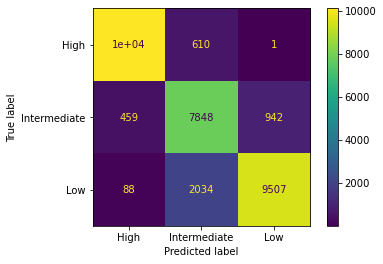

In [131]:
cm = confusion_matrix(XGB.predict(X_test),Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=XGB.classes_)
disp.plot()

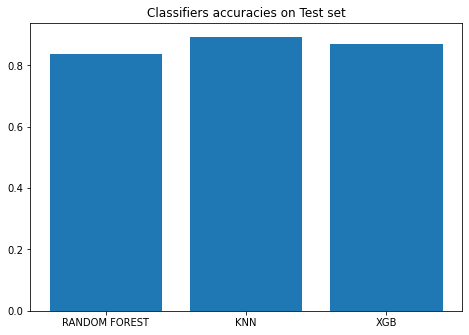

In [132]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['RANDOM FOREST', 'KNN', 'XGB']
ax.bar(models,classification_acc)
plt.title('Classifiers accuracies on Test set')
plt.show()

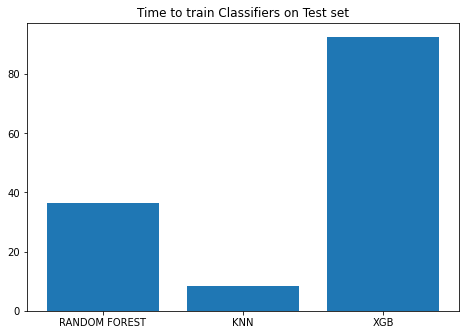

In [133]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['RANDOM FOREST', 'KNN', 'XGB']
ax.bar(models,time_to_train)
plt.title('Time to train Classifiers on Test set')
plt.show()

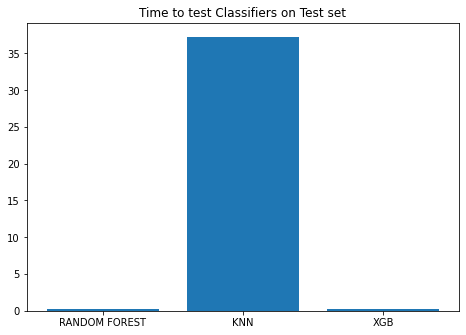

In [134]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['RANDOM FOREST', 'KNN', 'XGB']
ax.bar(models,time_to_test)
plt.title('Time to test Classifiers on Test set')
plt.show()

In [69]:
#%time svm = OneVsRestClassifier(SVC(kernel='linear',C=0.1)).fit(X,y)
#print("Accuracy on Training set = {acc}".format(acc = svm.score(X_train,Y_train)))#
#print("Accuracy on validation set = "+str(svm.score(X_valid,Y_valid)))

In [ ]:
filename = "C:\\Users\\Yousef\\Desktop\\ml\\saved_classification_models\\XGB.pkl"
pickle_rick.dump(XGB,open(filename,'wb'))

In [ ]:
def test_script(filepath,modelpath):
    test_data = pd.read_csv(filepath,parse_dates=['release_date'])
    test_data = test_data[~test_data.duplicated()==1]
    fill_missing_values(test_data)
    test_data = duration_to_minutes(test_data)
    test_data.drop(['name','id'],axis=1,inplace=True)
    test_data = feature_encoder(test_data,['artists'])
    testX,testY = test_data.drop('popularity_level',axis=1),test_data.popularity_level
    add_datepart(testX,'release_date')
    testX = MinMax_normalization(testX)
    m = pickle_rick.load(open(modelpath, 'rb'))
    print("Accuracy on test set is {acc}".format(acc=m.score(testX,testY)))

In [ ]:
test_file_path = "C:\\Users\\Yousef\\Desktop\\ml\\ML_Dataset\\test_set\\spotify_testing_classification.csv"
model_file_path = "C:\\Users\\Yousef\\Desktop\\ml\\saved_classification_models\\XGB.pkl"
test_script(test_file_path,model_file_path)